# Ανάκτηση και προεπεξεργασία δεδομένων σταθμού Kunak.

In [3]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error, r2_score, mean_squared_error
import seaborn as sns
#plt.style.use('seaborn')

#### Final Datetime 2022-09-05 00:00:00

In [4]:
df_raw = pd.read_csv('kunak.csv', delimiter=';', decimal=',', parse_dates=[1], index_col=1).drop(columns=['Device'])
df = df_raw.loc['2022-09-05 00:00:00':,:'Temp ext (C)']
df.columns = (['Dew Point (C)', 'H2S (ppb)', 'NO2 (ppb)', 'Humidity (%)',  'O3 (ppb)', 'PM1 (ug/m3)', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'Temp (C)'])
df

,Dew Point (C),H2S (ppb),NO2 (ppb),Humidity (%),O3 (ppb),PM1 (ug/m3),PM2.5 (ug/m3),PM10 (ug/m3),Temp (C)
Datetime,,,,,,,,,
2022-09-04 23:56:54,22.29,26.88,93.87,33.69,41.93,8.54,9.39,10.43,23.34
2022-09-04 23:51:55,22.02,25.43,91.27,33.99,42.37,9.56,10.42,11.59,23.52
2022-09-04 23:46:52,22.43,24.63,89.84,27.52,50.39,11.50,12.59,15.51,24.20
2022-09-04 23:41:55,21.93,28.97,82.17,30.50,47.97,16.09,17.93,40.74,25.19
2022-09-04 23:36:52,21.62,23.78,77.83,27.73,44.59,16.75,18.47,25.92,25.79
...,...,...,...,...,...,...,...,...,...
2022-04-10 00:22:25,9.80,12.92,60.55,40.90,0.00,6.18,8.09,10.73,17.53
2022-04-10 00:17:27,9.79,18.48,60.66,44.45,0.00,6.62,8.65,12.31,17.48
2022-04-10 00:12:25,9.78,14.61,60.45,41.50,0.00,5.97,7.88,11.72,17.53


In [5]:
df[df<0] = np.nan
print((df<0).sum())

Dew Point (C)    0
H2S (ppb)        0
NO2 (ppb)        0
Humidity (%)     0
O3 (ppb)         0
PM1 (ug/m3)      0
PM2.5 (ug/m3)    0
PM10 (ug/m3)     0
Temp (C)         0
dtype: int64


In [6]:
print(df.isna().sum())

Dew Point (C)    445
H2S (ppb)          0
NO2 (ppb)          0
Humidity (%)       0
O3 (ppb)           0
PM1 (ug/m3)       20
PM2.5 (ug/m3)     20
PM10 (ug/m3)      20
Temp (C)           0
dtype: int64


### Testing

In [7]:
target = 'NO2 (ppb)'
target_name = 'PM2.5' if target=='PM2.5 (ug/m3)' else target
df_test = df[:1000].copy().fillna(method='bfill')
nan_list = []
breaks = 15
missing_values = 12
for b in range(breaks+1):
    nan_list.append(int(df_test.shape[0]/breaks*b))

for i in nan_list[1:]:
    df_test[target].iloc[i:i+missing_values] = np.nan

df_test.isna().sum()

Dew Point (C)      0
H2S (ppb)          0
NO2 (ppb)        168
Humidity (%)       0
O3 (ppb)           0
PM1 (ug/m3)        0
PM2.5 (ug/m3)      0
PM10 (ug/m3)       0
Temp (C)           0
dtype: int64

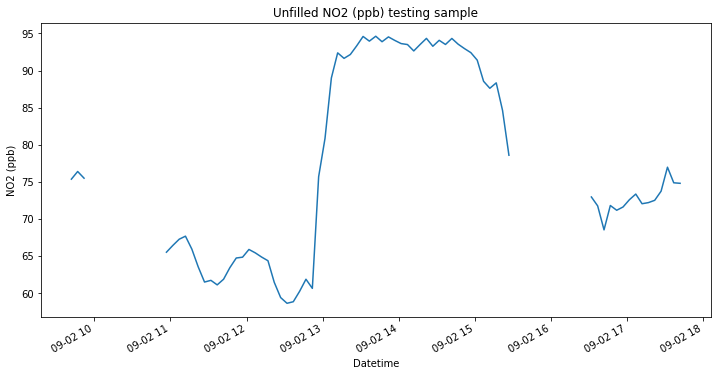

In [8]:
plt.figure(figsize=(12,6))
df_test[target][nan_list[10]-15:nan_list[11]+15].plot()
plt.ylabel(f"{target}")
#plt.tight_layout()
plt.title(f"Unfilled {target} testing sample")
plt.savefig(f'Plots/imputation/{target_name}_missing.png')
plt.show()

#### KNN Imputer

In [9]:
imputer = KNNImputer(n_neighbors=5)

df_knn = df_test.copy()
df_knn[:] = imputer.fit_transform(df_knn)

In [10]:
errors_list = [mean_absolute_error(df_knn[target], df[target][:1000]),
               mean_squared_error(df_knn[target], df[target][:1000]),
              r2_score(df_knn[target], df[target][:1000])]

errors_knn = pd.Series(errors_list,  index=['MAE','MSE', 'R2'])

#### Linear Interpolation

In [11]:
df_linear = df_test.copy()
df_linear.interpolate(method='linear', order=3,inplace=True)

In [12]:
errors_list = [mean_absolute_error(df_linear[target], df[target][:1000]),
               mean_squared_error(df_linear[target], df[target][:1000]),
              r2_score(df_linear[target], df[target][:1000])]

errors_linear = pd.Series(errors_list,  index=['MAE','MSE', 'R2'])

#### Cubic Interpolation

In [13]:
df_cubic = df_test.copy()
df_cubic.interpolate(method='cubic', order=3,inplace=True)

In [14]:
errors_list = [mean_absolute_error(df_cubic[target], df[target][:1000]),
               mean_squared_error(df_cubic[target], df[target][:1000]),
              r2_score(df_cubic[target], df[target][:1000])]

errors_cubic = pd.Series(errors_list,  index=['MAE','MSE', 'R2'])

#### Plotting

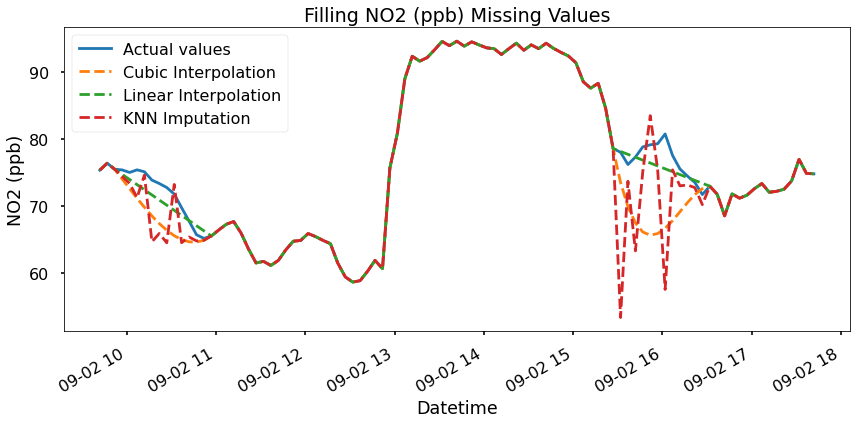

In [15]:
plt.style.use('seaborn-poster')
plt.figure(figsize=(12,6))

df[target][nan_list[10]-15:nan_list[11]+15].plot(label=f'Actual values')
df_cubic[target][nan_list[10]-15:nan_list[11]+15].plot(linestyle='--', label=f'Cubic Interpolation')
df_linear[target][nan_list[10]-15:nan_list[11]+15].plot(linestyle='--', label=f'Linear Interpolation')
df_knn[target][nan_list[10]-15:nan_list[11]+15].plot(linestyle='--', label=f'KNN Imputation')

plt.title(f"Filling {target} Missing Values")
plt.legend()
plt.ylabel(f"{target}")
plt.tight_layout()
plt.savefig(f'Plots/imputation/{target_name}_Imputation.png')
plt.show()

#### Errors concat

In [16]:
errors = pd.concat([errors_knn, errors_linear, errors_cubic], axis=1)
errors.columns = ['KNN', 'Linear', 'Cubic']
errors.round(3).T

,MAE,MSE,R2
KNN,0.676,6.056,0.975
Linear,0.167,0.338,0.999
Cubic,0.310,1.627,0.993


### Real: KNN Best

In [17]:
df[:] = imputer.fit_transform(df)
df.isna().sum()

Dew Point (C)    0
H2S (ppb)        0
NO2 (ppb)        0
Humidity (%)     0
O3 (ppb)         0
PM1 (ug/m3)      0
PM2.5 (ug/m3)    0
PM10 (ug/m3)     0
Temp (C)         0
dtype: int64

### Hourly mean

In [18]:
df_hour = round(df.resample('H').mean(),2)
df_hour.head()

,Dew Point (C),H2S (ppb),NO2 (ppb),Humidity (%),O3 (ppb),PM1 (ug/m3),PM2.5 (ug/m3),PM10 (ug/m3),Temp (C)
Datetime,,,,,,,,,
2022-04-10 00:00:00,9.74,16.60,60.03,42.00,0.00,6.61,8.56,12.61,17.60
2022-04-10 01:00:00,9.55,11.56,59.00,38.98,0.00,6.22,8.15,12.43,17.67
2022-04-10 02:00:00,9.39,13.33,59.05,37.07,0.00,6.26,8.22,12.04,17.49
2022-04-10 03:00:00,8.08,1.31,58.41,29.14,4.68,4.69,6.38,8.87,16.26
2022-04-10 04:00:00,7.46,0.33,58.28,29.25,2.04,3.49,4.99,7.16,15.64


In [19]:
df_hour.to_csv('kunak_filled.csv')